# Example: Forward Difference Discretization of a Bacterial Growth System
This example will familiarize students with constructing a forward-difference approximate solution for a system of non-linear ordinary differential equations (NODEs). In particular, we will explore a model for bacterial growth on a limiting carbon source (sugar) of the form:

$$
\begin{eqnarray}
\frac{dS}{dt} & = & -\frac{1}{Y}r_{g}\cdot{C}\\
\frac{dC}{dt} & = & \left(r_{g} - k_{d}\right)\cdot{C}
\end{eqnarray}
$$

where $S$ denotes the concentration of the limiting carbon source, e.g., glucose, $C$ denotes the cell mass concentration, $Y$ denotes the yields of cells per unit sugar, $r_{g}$ denotes the specific growth rate, and $k_{d}$ denotes the cell-death rate constant (units: 1/hr). We'll model the specific growth rate using the [Monod growth law]():

$$
r_{g} = \frac{\mu_{g}^{\text{max}}\cdot{S}}{K_{g}+S}
$$

where $\mu_{g}^{\text{max}}$ denotes the maximumn specific growth rate, and $K_{g}$ denotes the growth saturation constant.

## Setup
This example requires several external libraries and a function to compute the outer product. Let's download and install these packages and call our `Include.jl` file.

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9a`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9a/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9a/Manifest.toml`


## Prerequisites
Before we do any computation, let's specify some constant values, namely, the step size $h$ (which controls how fine the time resolution is), the maximum specific growth rate $\mu_{g}^{\text{max}}$ (units: 1/hr), the saturation coefficient $K_{g}$ (g/L), the yield $Y$, etc.

In [2]:
μgmax = 1.03; # units 1/h
K = 0.01; # units g/L
Y = 0.52; # units gdw/g
kd = 0.01; # units: 1/hr
h = 2.0; # units N/A
T = 10.0; # units hours

## Setup the growth rate function
We'll call the growth rate function in our main solution loop, passing the state matrix and the time index during each pass of the loop:

In [3]:
function μ(x::Array{Float64}, i::Int64; μgmax::Float64 = 0.0, K::Float64 = 0.0)

    # initialize -
    growth_rate = 0.0;
    S = x[i,1]; # we know that index 1 is S
    
    # compute the growth rate -
    growth_rate = (μgmax*S)/(K+S);
    
    # return -
    return growth_rate;
end;

## Setup the main simulation loop
We use a forward-difference approximation of the accumulation term, i.e., the time derivative, to turn the ordinary differential equations into non-linear difference equations that we evaluate iteratively. 
* To start, set up the `time_array` variable, which holds the time values that we want to simulate the system at and the initial conditions, i.e., the solution at time zero $\mathbf{x}(0) = \mathbf{x}_{\circ}$. Store the initial conditions in the `xₒ` variable:

In [4]:
time_array = range(0.0, stop=T, step=h) |> collect;
xₒ = [0.5, 0.005]; # initial conditions

Next, we'll evaluate the difference equations. The forward-difference approximation of the derivative for this system gives difference equations of the form:
$$
\begin{eqnarray}
S_{j} & = & S_{j-1} - \frac{h}{Y}\cdot{r}_{g}\cdot{C_{j-1}}\\
C_{j} & = & C_{j-1} + h\cdot\left(r_{g}-k_{d}\right)\cdot{C_{j-1}}
\end{eqnarray}
$$

where $h$ denotes the time step-size, $S_{j}, C_{j}$ denotes the estimates sugar and cellmass values at time index $j$. The growth rate function $r_{g}$ is evaluated at time step $j-1$.
* To implement this recursion, we initialize an $\dim{T}\times\dim\mathcal{S}$ array `X,` which will hold time values on the rows and state values, i.e., concentration estimates, on the columns.
* Then, we step through each index of the `time_array` array and compute the estimated states. Notice that we can update the state array `X` in place, i.e., we don't need to initialize additional storage across the additional time steps.

In [5]:
X = Array{Float64,2}(undef, length(time_array), length(xₒ));
for i ∈ eachindex(time_array)

    if (i == 1)
        X[i,1] = xₒ[1];
        X[i,2] = xₒ[2];
    else

        # compute the growth rate -
        mu = μ(X, i-1, μgmax = μgmax, K = K);

        # update the estimated solution using the recurrence relation
        X[i,1] = X[i-1,1] - (h/Y)*mu*X[i-1,2]; # everyting on the rhs is at time index j - 1
        X[i,2] = X[i-1,2] + h*(mu - kd)*X[i-1,2];
    end
end

## Visualize
`Unhide` the code block below to see how we plotted the estimated numerical solution for the batch culture Bacterial growth model.

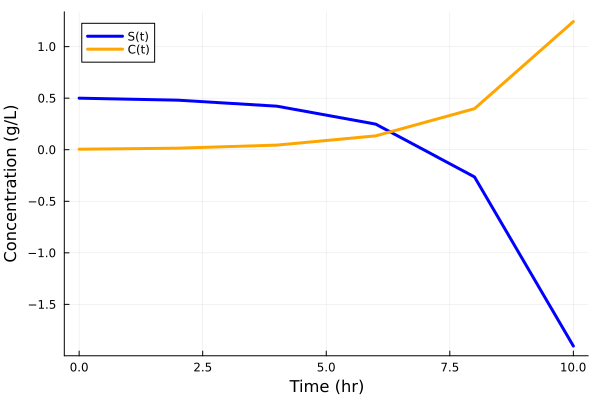

In [6]:
plot(time_array,X[:,1], lw=3, label="S(t)", c=:blue)
plot!(time_array,X[:,2], lw=3, label="C(t)", c=:orange)
xlabel!("Time (hr)", fontsize=18)
ylabel!("Concentration (g/L)", fontsize=18)